In [596]:
# 导入必要的库
import numpy as np
import keras
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tool import evalIndicator

In [597]:
# 读取数据，划分数据集
df = pd.read_csv("/Users/datou/PycharmProjects/model/JianyangSta/JY_data/建阳站日降雨径流蒸发资料(完整）.csv", parse_dates=["Date"])
df_copy = df
df.reset_index(drop=True)
df = df.set_index('Date')
df

,Q,P
Date,,
2000-03-04,95.218583,2.779
2000-03-05,111.431333,2.721
2000-03-06,92.994458,1.991
2000-03-07,90.252708,5.497
2000-03-08,86.227667,4.970
...,...,...
2018-10-26,39.116250,8.492
2018-10-27,46.711250,5.857
2018-10-28,70.970417,3.264


In [598]:
#定义时间窗
n_past=1

In [599]:
# 划分数据
test_split = round(len(df) * 0.3)
df_for_training = df[:-test_split]
df_for_testing = df[-(test_split+n_past):]
df_for_training.shape

(4771, 2)

In [600]:
# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)

In [601]:
# 创建数据集，n_past：时间步长
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)


In [602]:
"""
网络中的第一层必须定义预期输入数。输入必须是三维的，由Samples、Timesteps和Features组成。
Samples：数据中的行
Timesteps：特征的过去观测值
features：数据中的列
"""
# 这里使用30，意味着将使用过去的30个值(包括目标列在内的所有特性)来预测第31个目标值。
trainX, trainY = createXY(df_for_training_scaled, n_past)
trainX.shape, trainY.shape

((4770, 1, 2), (4770,))

In [603]:
testX, testY = createXY(df_for_testing_scaled, n_past)
testX.shape, testY.shape

((2044, 1, 2), (2044,))

In [604]:
# 建立模型
def build_model():
    """
    1、定义网络
    """
    grid_model = Sequential()  # 层次模型
    """
    指定input_shape，该参数需要包含时间步长数和特征数的元组。
    input_shape=(时间步长数，特征数元组)：
    此处采用时间步长数30，特征数元组长度为2
    LSTM 图层可以通过将它们添加到顺序模型来堆叠。
    重要的是，在堆叠 LSTM 图层时，我们必须为每个输入输出一个序列而不是单个值，以便后续 LSTM 图层可以具有所需的 3D 输入。
    通过将"return_sequences true"实现
    """
    grid_model.add(LSTM(50, return_sequences=True, input_shape=(n_past, 2)))
    """
    第一步是创建顺序类的实例。然后，创建图层，并按应连接它们的顺序添加它们。
    由内存单元组成的LSTM循环层称为LSTM（）。
    通常跟随 LSTM 图层并用于输出预测的完全连接层称为 Dense（）。
    """
    grid_model.add(LSTM(100))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    learning_rate =3e-3
    """
    编译网络：编译需要指定许多参数，这些参数是专为培训网络而定制的。具体来说，用于训练网络和用于评估优化算法最小化的网络的优化算法。
    model.compile(optimizer,loss)
    """
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    grid_model.compile(loss='mse', optimizer=optimizer)
    return grid_model


In [605]:
# 交叉搜索，寻求模型最佳参数，并输出最佳模型
parameters = {'batch_size': [16,20],
              'epochs': [20,50,100]}
"""
verbose参数设置为 2，可以将显示的信息量减小到每轮训练的损失。
可以通过将verbose设置为 1 来关闭所有输出
"""
# grid_model = KerasRegressor(build_fn=build_model, verbose=1, validation_data=(testX, testY))
grid_model = KerasRegressor(build_fn=build_model, verbose=1)
grid_search = GridSearchCV(estimator=grid_model, param_grid=parameters,
                           cv=5)

/var/folders/p_/spnxgg1953n3fzj8z81sv51r0000gn/T/ipykernel_39134/2791461057.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model, verbose=1)


In [606]:
"""
训练网络
"""
grid_search = grid_search.fit(trainX, trainY)
# 将最佳模型保存在my_model变量中
my_model = grid_search.best_estimator_

Epoch 1/20


2024-03-19 11:43:43.772503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:43:43.772962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:43:43.773568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 7.4491e-04
Epoch 2/20
239/239 [==============================] - 0s 1ms/step - loss: 6.9511e-04
Epoch 3/20
239/239 [==============================] - 0s 1ms/step - loss: 5.3324e-04
Epoch 4/20
239/239 [==============================] - 0s 1ms/step - loss: 5.6576e-04
Epoch 5/20
239/239 [==============================] - 0s 1ms/step - loss: 5.3493e-04
Epoch 6/20
239/239 [==============================] - 0s 1ms/step - loss: 4.9819e-04
Epoch 7/20
239/239 [==============================] - 0s 1ms/step - loss: 4.9806e-04
Epoch 8/20
239/239 [==============================] - 0s 1ms/step - loss: 5.5142e-04
Epoch 9/20
239/239 [==============================] - 0s 1ms/step - loss: 4.9848e-04
Epoch 10/20
239/239 [==============================] - 0s 1ms/step - loss: 4.5723e-04
Epoch 11/20
239/239 [==============================] - 0s 1ms/step - loss: 4.4357e-04
Epoch 12/20
239/239 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:43:50.247348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:43:50.247869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:43:50.248675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-03-19 11:43:50.481197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:43:50.481932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:43:50.482343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 6.8622e-04
Epoch 2/20
239/239 [==============================] - 0s 1ms/step - loss: 6.2681e-04
Epoch 3/20
239/239 [==============================] - 0s 1ms/step - loss: 6.5495e-04
Epoch 4/20
239/239 [==============================] - 0s 1ms/step - loss: 5.7186e-04
Epoch 5/20
239/239 [==============================] - 0s 1ms/step - loss: 5.5374e-04
Epoch 6/20
239/239 [==============================] - 0s 1ms/step - loss: 5.7555e-04
Epoch 7/20
239/239 [==============================] - 0s 1ms/step - loss: 5.6103e-04
Epoch 8/20
239/239 [==============================] - 0s 1000us/step - loss: 5.5109e-04
Epoch 9/20
239/239 [==============================] - 0s 1ms/step - loss: 5.0523e-04
Epoch 10/20
239/239 [==============================] - 0s 1ms/step - loss: 6.0307e-04
Epoch 11/20
239/239 [==============================] - 0s 1ms/step - loss: 4.9714e-04
Epoch 12/20
239/239 [==============================] - 0s 1ms/step - lo

2024-03-19 11:43:56.438519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:43:56.439179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:43:56.439520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-03-19 11:43:56.668562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:43:56.668986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:43:56.669535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 6.8637e-04
Epoch 2/20
239/239 [==============================] - 0s 1ms/step - loss: 5.7725e-04
Epoch 3/20
239/239 [==============================] - 0s 1ms/step - loss: 5.4987e-04
Epoch 4/20
239/239 [==============================] - 0s 999us/step - loss: 5.2415e-04
Epoch 5/20
239/239 [==============================] - 0s 998us/step - loss: 4.7856e-04
Epoch 6/20
239/239 [==============================] - 0s 1ms/step - loss: 4.7689e-04
Epoch 7/20
239/239 [==============================] - 0s 1ms/step - loss: 4.8448e-04
Epoch 8/20
239/239 [==============================] - 0s 1ms/step - loss: 4.6177e-04
Epoch 9/20
239/239 [==============================] - 0s 1ms/step - loss: 5.0212e-04
Epoch 10/20
239/239 [==============================] - 0s 1ms/step - loss: 4.3478e-04
Epoch 11/20
239/239 [==============================] - 0s 1ms/step - loss: 3.9461e-04
Epoch 12/20
239/239 [==============================] - 0s 1ms/step - l

2024-03-19 11:44:02.547073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:44:02.547721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:44:02.548127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-03-19 11:44:02.773946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:44:02.774819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:44:02.775379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 6.0819e-04
Epoch 2/20
239/239 [==============================] - 0s 1ms/step - loss: 5.1543e-04
Epoch 3/20
239/239 [==============================] - 0s 1ms/step - loss: 4.3987e-04
Epoch 4/20
239/239 [==============================] - 0s 1ms/step - loss: 4.2357e-04
Epoch 5/20
239/239 [==============================] - 0s 1ms/step - loss: 4.6294e-04
Epoch 6/20
239/239 [==============================] - 0s 1ms/step - loss: 4.5103e-04
Epoch 7/20
239/239 [==============================] - 0s 1ms/step - loss: 4.5346e-04
Epoch 8/20
239/239 [==============================] - 0s 1ms/step - loss: 4.1694e-04
Epoch 9/20
239/239 [==============================] - 0s 1ms/step - loss: 4.2985e-04
Epoch 10/20
239/239 [==============================] - 0s 1ms/step - loss: 4.2748e-04
Epoch 11/20
239/239 [==============================] - 0s 1ms/step - loss: 4.2590e-04
Epoch 12/20
239/239 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:44:08.724726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:44:08.725311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:44:08.725739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

60/60 [==============================] - 1s 488us/step - loss: 5.5942e-04


2024-03-19 11:44:09.115795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:44:09.116316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:44:09.116906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-03-19 11:44:09.356836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:44:09.357400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:44:09.357902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 7.7296e-04
Epoch 2/20
239/239 [==============================] - 0s 1ms/step - loss: 5.7291e-04
Epoch 3/20
239/239 [==============================] - 0s 998us/step - loss: 5.3177e-04
Epoch 4/20
239/239 [==============================] - 0s 1ms/step - loss: 5.5002e-04
Epoch 5/20
239/239 [==============================] - 0s 1ms/step - loss: 4.8937e-04
Epoch 6/20
239/239 [==============================] - 0s 1ms/step - loss: 4.6116e-04
Epoch 7/20
239/239 [==============================] - 0s 1ms/step - loss: 5.3094e-04
Epoch 8/20
239/239 [==============================] - 0s 998us/step - loss: 4.8313e-04
Epoch 9/20
239/239 [==============================] - 0s 1ms/step - loss: 4.5598e-04
Epoch 10/20
239/239 [==============================] - 0s 1ms/step - loss: 4.6738e-04
Epoch 11/20
239/239 [==============================] - 0s 1ms/step - loss: 4.6349e-04
Epoch 12/20
239/239 [==============================] - 0s 1ms/step - l

2024-03-19 11:44:15.594226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:44:15.594642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:44:15.595170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-03-19 11:44:15.826378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:44:15.826969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:44:15.827583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 7.4135e-04
Epoch 2/50
239/239 [==============================] - 0s 1ms/step - loss: 5.2991e-04
Epoch 3/50
239/239 [==============================] - 0s 998us/step - loss: 5.8899e-04
Epoch 4/50
239/239 [==============================] - 0s 1ms/step - loss: 5.3268e-04
Epoch 5/50
239/239 [==============================] - 0s 1ms/step - loss: 5.7962e-04
Epoch 6/50
239/239 [==============================] - 0s 1000us/step - loss: 5.2819e-04
Epoch 7/50
239/239 [==============================] - 0s 1ms/step - loss: 4.7966e-04
Epoch 8/50
239/239 [==============================] - 0s 987us/step - loss: 4.6354e-04
Epoch 9/50
239/239 [==============================] - 0s 1ms/step - loss: 4.8170e-04
Epoch 10/50
239/239 [==============================] - 0s 1ms/step - loss: 4.9334e-04
Epoch 11/50
239/239 [==============================] - 0s 1ms/step - loss: 5.1833e-04
Epoch 12/50
239/239 [==============================] - 0s 1ms/step 

2024-03-19 11:44:29.344297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:44:29.345031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:44:29.345398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-03-19 11:44:29.588916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:44:29.589462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:44:29.590065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 8.3636e-04
Epoch 2/50
239/239 [==============================] - 0s 1ms/step - loss: 6.6538e-04
Epoch 3/50
239/239 [==============================] - 0s 1ms/step - loss: 5.5263e-04
Epoch 4/50
239/239 [==============================] - 0s 1ms/step - loss: 5.7995e-04
Epoch 5/50
239/239 [==============================] - 0s 1ms/step - loss: 6.2451e-04
Epoch 6/50
239/239 [==============================] - 0s 1ms/step - loss: 5.6879e-04
Epoch 7/50
239/239 [==============================] - 0s 1ms/step - loss: 5.4190e-04
Epoch 8/50
239/239 [==============================] - 0s 1ms/step - loss: 5.9562e-04
Epoch 9/50
239/239 [==============================] - 0s 1ms/step - loss: 5.7663e-04
Epoch 10/50
239/239 [==============================] - 0s 1ms/step - loss: 5.1428e-04
Epoch 11/50
239/239 [==============================] - 0s 1ms/step - loss: 5.5811e-04
Epoch 12/50
239/239 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:44:43.073307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:44:43.073720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:44:43.074252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-03-19 11:44:43.311019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:44:43.311553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:44:43.312030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 7.1941e-04
Epoch 2/50
239/239 [==============================] - 0s 1ms/step - loss: 5.0925e-04
Epoch 3/50
239/239 [==============================] - 0s 1ms/step - loss: 4.8242e-04
Epoch 4/50
239/239 [==============================] - 0s 1ms/step - loss: 4.8183e-04
Epoch 5/50
239/239 [==============================] - 0s 1ms/step - loss: 5.5841e-04
Epoch 6/50
239/239 [==============================] - 0s 1ms/step - loss: 4.4454e-04
Epoch 7/50
239/239 [==============================] - 0s 1ms/step - loss: 4.6036e-04
Epoch 8/50
239/239 [==============================] - 0s 1ms/step - loss: 4.4380e-04
Epoch 9/50
239/239 [==============================] - 0s 1ms/step - loss: 4.6614e-04
Epoch 10/50
239/239 [==============================] - 0s 1ms/step - loss: 4.3684e-04
Epoch 11/50
239/239 [==============================] - 0s 1ms/step - loss: 4.4817e-04
Epoch 12/50
239/239 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:44:57.244287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:44:57.244810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:44:57.245308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-03-19 11:44:57.483537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:44:57.483992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:44:57.484477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 6.4227e-04
Epoch 2/50
239/239 [==============================] - 0s 1ms/step - loss: 4.4551e-04
Epoch 3/50
239/239 [==============================] - 0s 1ms/step - loss: 4.5550e-04
Epoch 4/50
239/239 [==============================] - 0s 1ms/step - loss: 4.1844e-04
Epoch 5/50
239/239 [==============================] - 0s 1ms/step - loss: 4.4376e-04
Epoch 6/50
239/239 [==============================] - 0s 1ms/step - loss: 4.3246e-04
Epoch 7/50
239/239 [==============================] - 0s 1ms/step - loss: 4.4511e-04
Epoch 8/50
239/239 [==============================] - 0s 1ms/step - loss: 4.1594e-04
Epoch 9/50
239/239 [==============================] - 0s 1ms/step - loss: 4.4943e-04
Epoch 10/50
239/239 [==============================] - 0s 1ms/step - loss: 4.5561e-04
Epoch 11/50
239/239 [==============================] - 0s 1ms/step - loss: 4.3085e-04
Epoch 12/50
239/239 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:45:10.978040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:45:10.978479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:45:10.979082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-03-19 11:45:11.211847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:45:11.212493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:45:11.212829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 8.5749e-04
Epoch 2/50
239/239 [==============================] - 0s 1ms/step - loss: 5.3282e-04
Epoch 3/50
239/239 [==============================] - 0s 1ms/step - loss: 5.3750e-04
Epoch 4/50
239/239 [==============================] - 0s 1ms/step - loss: 6.0452e-04
Epoch 5/50
239/239 [==============================] - 0s 1ms/step - loss: 4.8946e-04
Epoch 6/50
239/239 [==============================] - 0s 1ms/step - loss: 5.1193e-04
Epoch 7/50
239/239 [==============================] - 0s 1ms/step - loss: 4.5547e-04
Epoch 8/50
239/239 [==============================] - 0s 1ms/step - loss: 4.4737e-04
Epoch 9/50
239/239 [==============================] - 0s 1ms/step - loss: 5.6650e-04
Epoch 10/50
239/239 [==============================] - 0s 1ms/step - loss: 4.5880e-04
Epoch 11/50
239/239 [==============================] - 0s 1ms/step - loss: 4.4763e-04
Epoch 12/50
239/239 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:45:24.478485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:45:24.479074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:45:24.479422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-03-19 11:45:24.716709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:45:24.717301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:45:24.717665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 7.6768e-04
Epoch 2/100
239/239 [==============================] - 0s 1ms/step - loss: 5.7981e-04
Epoch 3/100
239/239 [==============================] - 0s 1ms/step - loss: 5.2125e-04
Epoch 4/100
239/239 [==============================] - 0s 1ms/step - loss: 5.5300e-04
Epoch 5/100
239/239 [==============================] - 0s 1ms/step - loss: 5.2723e-04
Epoch 6/100
239/239 [==============================] - 0s 1ms/step - loss: 5.3785e-04
Epoch 7/100
239/239 [==============================] - 0s 1ms/step - loss: 5.0733e-04
Epoch 8/100
239/239 [==============================] - 0s 1ms/step - loss: 4.6229e-04
Epoch 9/100
239/239 [==============================] - 0s 1ms/step - loss: 5.1973e-04
Epoch 10/100
239/239 [==============================] - 0s 1ms/step - loss: 5.2263e-04
Epoch 11/100
239/239 [==============================] - 0s 1ms/step - loss: 4.9257e-04
Epoch 12/100
239/239 [==============================] - 0s 1ms/s

2024-03-19 11:45:51.247705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:45:51.248377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:45:51.248811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-03-19 11:45:51.485803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:45:51.486345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:45:51.486720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 7.5453e-04
Epoch 2/100
239/239 [==============================] - 0s 1ms/step - loss: 6.5798e-04
Epoch 3/100
239/239 [==============================] - 0s 1ms/step - loss: 5.5520e-04
Epoch 4/100
239/239 [==============================] - 0s 1ms/step - loss: 6.5955e-04
Epoch 5/100
239/239 [==============================] - 0s 1ms/step - loss: 5.6094e-04
Epoch 6/100
239/239 [==============================] - 0s 1ms/step - loss: 5.8195e-04
Epoch 7/100
239/239 [==============================] - 0s 1ms/step - loss: 5.7884e-04
Epoch 8/100
239/239 [==============================] - 0s 1ms/step - loss: 5.5104e-04
Epoch 9/100
239/239 [==============================] - 0s 1ms/step - loss: 5.0874e-04
Epoch 10/100
239/239 [==============================] - 0s 1ms/step - loss: 5.3064e-04
Epoch 11/100
239/239 [==============================] - 0s 1ms/step - loss: 4.9140e-04
Epoch 12/100
239/239 [==============================] - 0s 1ms/s

2024-03-19 11:46:19.994998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:46:19.995625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:46:19.996130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-03-19 11:46:20.238241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:46:20.238851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:46:20.239282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 6.8754e-04
Epoch 2/100
239/239 [==============================] - 0s 1ms/step - loss: 5.4226e-04
Epoch 3/100
239/239 [==============================] - 0s 1ms/step - loss: 5.8820e-04
Epoch 4/100
239/239 [==============================] - 0s 1ms/step - loss: 4.9597e-04
Epoch 5/100
239/239 [==============================] - 0s 1ms/step - loss: 4.9256e-04
Epoch 6/100
239/239 [==============================] - 0s 1ms/step - loss: 4.8775e-04
Epoch 7/100
239/239 [==============================] - 0s 1ms/step - loss: 4.1761e-04
Epoch 8/100
239/239 [==============================] - 0s 1ms/step - loss: 4.2389e-04
Epoch 9/100
239/239 [==============================] - 0s 1ms/step - loss: 4.4150e-04
Epoch 10/100
239/239 [==============================] - 0s 1ms/step - loss: 4.9658e-04
Epoch 11/100
239/239 [==============================] - 0s 1ms/step - loss: 4.1203e-04
Epoch 12/100
239/239 [==============================] - 0s 1ms/s

2024-03-19 11:46:46.096355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:46:46.097073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:46:46.097529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-03-19 11:46:46.331476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:46:46.332114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:46:46.332514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 5.5508e-04
Epoch 2/100
239/239 [==============================] - 0s 1ms/step - loss: 4.6236e-04
Epoch 3/100
239/239 [==============================] - 0s 1ms/step - loss: 4.5469e-04
Epoch 4/100
239/239 [==============================] - 0s 1ms/step - loss: 4.7261e-04
Epoch 5/100
239/239 [==============================] - 0s 1ms/step - loss: 4.7262e-04
Epoch 6/100
239/239 [==============================] - 0s 1ms/step - loss: 4.2979e-04
Epoch 7/100
239/239 [==============================] - 0s 988us/step - loss: 4.3006e-04
Epoch 8/100
239/239 [==============================] - 0s 1ms/step - loss: 4.1174e-04
Epoch 9/100
239/239 [==============================] - 0s 998us/step - loss: 4.6037e-04
Epoch 10/100
239/239 [==============================] - 0s 1ms/step - loss: 4.3085e-04
Epoch 11/100
239/239 [==============================] - 0s 991us/step - loss: 4.1158e-04
Epoch 12/100
239/239 [==============================] - 0s

2024-03-19 11:47:12.275306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:47:12.276028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:47:12.276454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-03-19 11:47:12.514438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:47:12.514905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:47:12.515331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 8.8511e-04
Epoch 2/100
239/239 [==============================] - 0s 1ms/step - loss: 5.4133e-04
Epoch 3/100
239/239 [==============================] - 0s 1ms/step - loss: 5.0219e-04
Epoch 4/100
239/239 [==============================] - 0s 1ms/step - loss: 5.3271e-04
Epoch 5/100
239/239 [==============================] - 0s 1ms/step - loss: 5.3136e-04
Epoch 6/100
239/239 [==============================] - 0s 1ms/step - loss: 5.0303e-04
Epoch 7/100
239/239 [==============================] - 0s 1ms/step - loss: 4.6462e-04
Epoch 8/100
239/239 [==============================] - 0s 1ms/step - loss: 5.0134e-04
Epoch 9/100
239/239 [==============================] - 0s 1ms/step - loss: 4.3093e-04
Epoch 10/100
239/239 [==============================] - 0s 1ms/step - loss: 4.7677e-04
Epoch 11/100
239/239 [==============================] - 0s 1ms/step - loss: 4.1802e-04
Epoch 12/100
239/239 [==============================] - 0s 1ms/s

2024-03-19 11:47:40.398218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:47:40.398848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:47:40.399523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

60/60 [==============================] - 0s 548us/step - loss: 4.2033e-04
Epoch 1/20


2024-03-19 11:47:40.658730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:47:40.659365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:47:40.659800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 6.7969e-04
Epoch 2/20
191/191 [==============================] - 0s 1ms/step - loss: 5.4821e-04
Epoch 3/20
191/191 [==============================] - 0s 1ms/step - loss: 5.3518e-04
Epoch 4/20
191/191 [==============================] - 0s 1ms/step - loss: 5.4383e-04
Epoch 5/20
191/191 [==============================] - 0s 1ms/step - loss: 5.0882e-04
Epoch 6/20
191/191 [==============================] - 0s 1ms/step - loss: 6.4489e-04
Epoch 7/20
191/191 [==============================] - 0s 1ms/step - loss: 6.1427e-04
Epoch 8/20
191/191 [==============================] - 0s 1ms/step - loss: 5.1903e-04
Epoch 9/20
191/191 [==============================] - 0s 1ms/step - loss: 5.0962e-04
Epoch 10/20
191/191 [==============================] - 0s 1ms/step - loss: 4.8426e-04
Epoch 11/20
191/191 [==============================] - 0s 1ms/step - loss: 4.3822e-04
Epoch 12/20
191/191 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:47:46.151474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:47:46.152058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:47:46.152444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

48/48 [==============================] - 1s 535us/step - loss: 3.8044e-04


2024-03-19 11:47:46.636323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:47:46.636880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:47:46.637380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-03-19 11:47:46.886268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:47:46.886725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:47:46.887235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 8.5543e-04
Epoch 2/20
191/191 [==============================] - 0s 1ms/step - loss: 5.7925e-04
Epoch 3/20
191/191 [==============================] - 0s 1ms/step - loss: 6.3002e-04
Epoch 4/20
191/191 [==============================] - 0s 1ms/step - loss: 6.2324e-04
Epoch 5/20
191/191 [==============================] - 0s 1ms/step - loss: 5.7672e-04
Epoch 6/20
191/191 [==============================] - 0s 1ms/step - loss: 6.4636e-04
Epoch 7/20
191/191 [==============================] - 0s 1ms/step - loss: 5.6280e-04
Epoch 8/20
191/191 [==============================] - 0s 1ms/step - loss: 5.6176e-04
Epoch 9/20
191/191 [==============================] - 0s 1ms/step - loss: 5.1296e-04
Epoch 10/20
191/191 [==============================] - 0s 1ms/step - loss: 5.6898e-04
Epoch 11/20
191/191 [==============================] - 0s 1ms/step - loss: 5.7004e-04
Epoch 12/20
191/191 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:47:52.070231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:47:52.070817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:47:52.071218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-03-19 11:47:52.298856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:47:52.299493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:47:52.299844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 6.4695e-04
Epoch 2/20
191/191 [==============================] - 0s 1ms/step - loss: 5.1113e-04
Epoch 3/20
191/191 [==============================] - 0s 1ms/step - loss: 5.0451e-04
Epoch 4/20
191/191 [==============================] - 0s 1ms/step - loss: 4.7872e-04
Epoch 5/20
191/191 [==============================] - 0s 1ms/step - loss: 4.8372e-04
Epoch 6/20
191/191 [==============================] - 0s 1ms/step - loss: 5.2956e-04
Epoch 7/20
191/191 [==============================] - 0s 1ms/step - loss: 4.6909e-04
Epoch 8/20
191/191 [==============================] - 0s 1ms/step - loss: 5.0950e-04
Epoch 9/20
191/191 [==============================] - 0s 1ms/step - loss: 4.5884e-04
Epoch 10/20
191/191 [==============================] - 0s 1ms/step - loss: 4.5367e-04
Epoch 11/20
191/191 [==============================] - 0s 1ms/step - loss: 4.0305e-04
Epoch 12/20
191/191 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:47:57.649397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:47:57.649941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:47:57.650623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-03-19 11:47:57.893075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:47:57.893529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:47:57.894020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 6.3422e-04
Epoch 2/20
191/191 [==============================] - 0s 1ms/step - loss: 4.8987e-04
Epoch 3/20
191/191 [==============================] - 0s 1ms/step - loss: 4.6604e-04
Epoch 4/20
191/191 [==============================] - 0s 1ms/step - loss: 4.2570e-04
Epoch 5/20
191/191 [==============================] - 0s 1ms/step - loss: 4.4200e-04
Epoch 6/20
191/191 [==============================] - 0s 1ms/step - loss: 4.3754e-04
Epoch 7/20
191/191 [==============================] - 0s 1ms/step - loss: 4.5217e-04
Epoch 8/20
191/191 [==============================] - 0s 1ms/step - loss: 4.3592e-04
Epoch 9/20
191/191 [==============================] - 0s 1ms/step - loss: 4.0619e-04
Epoch 10/20
191/191 [==============================] - 0s 1ms/step - loss: 4.2960e-04
Epoch 11/20
191/191 [==============================] - 0s 1ms/step - loss: 4.5494e-04
Epoch 12/20
191/191 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:48:03.324121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:48:03.324761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:48:03.325260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-03-19 11:48:03.563689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:48:03.564267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:48:03.564668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 7.1174e-04
Epoch 2/20
191/191 [==============================] - 0s 1ms/step - loss: 5.9506e-04
Epoch 3/20
191/191 [==============================] - 0s 1ms/step - loss: 5.1156e-04
Epoch 4/20
191/191 [==============================] - 0s 1ms/step - loss: 5.0209e-04
Epoch 5/20
191/191 [==============================] - 0s 1ms/step - loss: 5.0259e-04
Epoch 6/20
191/191 [==============================] - 0s 1ms/step - loss: 4.9874e-04
Epoch 7/20
191/191 [==============================] - 0s 1ms/step - loss: 4.9405e-04
Epoch 8/20
191/191 [==============================] - 0s 1ms/step - loss: 4.6760e-04
Epoch 9/20
191/191 [==============================] - 0s 1ms/step - loss: 4.8127e-04
Epoch 10/20
191/191 [==============================] - 0s 1ms/step - loss: 4.4063e-04
Epoch 11/20
191/191 [==============================] - 0s 1ms/step - loss: 5.1211e-04
Epoch 12/20
191/191 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:48:09.005607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:48:09.006229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:48:09.006633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-03-19 11:48:09.667959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:48:09.668680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:48:09.669069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 7.9329e-04
Epoch 2/50
191/191 [==============================] - 0s 1ms/step - loss: 5.9073e-04
Epoch 3/50
191/191 [==============================] - 0s 1ms/step - loss: 5.4060e-04
Epoch 4/50
191/191 [==============================] - 0s 1ms/step - loss: 5.4396e-04
Epoch 5/50
191/191 [==============================] - 0s 1ms/step - loss: 4.8779e-04
Epoch 6/50
191/191 [==============================] - 0s 1ms/step - loss: 5.1846e-04
Epoch 7/50
191/191 [==============================] - 0s 1ms/step - loss: 5.3705e-04
Epoch 8/50
191/191 [==============================] - 0s 1ms/step - loss: 5.3211e-04
Epoch 9/50
191/191 [==============================] - 0s 1ms/step - loss: 5.0784e-04
Epoch 10/50
191/191 [==============================] - 0s 1ms/step - loss: 4.6578e-04
Epoch 11/50
191/191 [==============================] - 0s 1ms/step - loss: 5.1706e-04
Epoch 12/50
191/191 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:48:21.482234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:48:21.482649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:48:21.483504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-03-19 11:48:21.739301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:48:21.740163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:48:21.740865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 7.9259e-04
Epoch 2/50
191/191 [==============================] - 0s 1ms/step - loss: 6.0103e-04
Epoch 3/50
191/191 [==============================] - 0s 1ms/step - loss: 6.2536e-04
Epoch 4/50
191/191 [==============================] - 0s 1ms/step - loss: 5.7672e-04
Epoch 5/50
191/191 [==============================] - 0s 1ms/step - loss: 5.8574e-04
Epoch 6/50
191/191 [==============================] - 0s 1ms/step - loss: 5.7994e-04
Epoch 7/50
191/191 [==============================] - 0s 1ms/step - loss: 5.6372e-04
Epoch 8/50
191/191 [==============================] - 0s 1ms/step - loss: 5.6859e-04
Epoch 9/50
191/191 [==============================] - 0s 1ms/step - loss: 5.3749e-04
Epoch 10/50
191/191 [==============================] - 0s 1ms/step - loss: 5.3288e-04
Epoch 11/50
191/191 [==============================] - 0s 1ms/step - loss: 5.4814e-04
Epoch 12/50
191/191 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:48:35.009783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:48:35.010436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:48:35.010937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-03-19 11:48:35.260155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:48:35.260611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:48:35.261183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 6.4111e-04
Epoch 2/50
191/191 [==============================] - 0s 1ms/step - loss: 4.7449e-04
Epoch 3/50
191/191 [==============================] - 0s 1ms/step - loss: 5.0866e-04
Epoch 4/50
191/191 [==============================] - 0s 1ms/step - loss: 5.0317e-04
Epoch 5/50
191/191 [==============================] - 0s 1ms/step - loss: 4.9398e-04
Epoch 6/50
191/191 [==============================] - 0s 1ms/step - loss: 4.6887e-04
Epoch 7/50
191/191 [==============================] - 0s 1ms/step - loss: 4.9206e-04
Epoch 8/50
191/191 [==============================] - 0s 1ms/step - loss: 5.1651e-04
Epoch 9/50
191/191 [==============================] - 0s 1ms/step - loss: 4.5575e-04
Epoch 10/50
191/191 [==============================] - 0s 1ms/step - loss: 4.5320e-04
Epoch 11/50
191/191 [==============================] - 0s 1ms/step - loss: 3.9899e-04
Epoch 12/50
191/191 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:48:47.715541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:48:47.716065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:48:47.716528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-03-19 11:48:47.961791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:48:47.962242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:48:47.962789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 6.0437e-04
Epoch 2/50
191/191 [==============================] - 0s 1ms/step - loss: 4.5894e-04
Epoch 3/50
191/191 [==============================] - 0s 1ms/step - loss: 4.4966e-04
Epoch 4/50
191/191 [==============================] - 0s 1ms/step - loss: 4.2430e-04
Epoch 5/50
191/191 [==============================] - 0s 1ms/step - loss: 4.5955e-04
Epoch 6/50
191/191 [==============================] - 0s 1ms/step - loss: 4.4820e-04
Epoch 7/50
191/191 [==============================] - 0s 1ms/step - loss: 4.3395e-04
Epoch 8/50
191/191 [==============================] - 0s 1ms/step - loss: 4.3197e-04
Epoch 9/50
191/191 [==============================] - 0s 1ms/step - loss: 4.4677e-04
Epoch 10/50
191/191 [==============================] - 0s 1ms/step - loss: 4.4561e-04
Epoch 11/50
191/191 [==============================] - 0s 1ms/step - loss: 4.2710e-04
Epoch 12/50
191/191 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:48:59.940501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:48:59.941190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:48:59.941926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-03-19 11:49:00.185752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:49:00.186170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:49:00.186793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 2s 1ms/step - loss: 7.8644e-04
Epoch 2/50
191/191 [==============================] - 0s 1ms/step - loss: 5.5951e-04
Epoch 3/50
191/191 [==============================] - 0s 1ms/step - loss: 5.0727e-04
Epoch 4/50
191/191 [==============================] - 0s 1ms/step - loss: 4.8542e-04
Epoch 5/50
191/191 [==============================] - 0s 1ms/step - loss: 5.4152e-04
Epoch 6/50
191/191 [==============================] - 0s 1ms/step - loss: 4.6652e-04
Epoch 7/50
191/191 [==============================] - 0s 1ms/step - loss: 5.0360e-04
Epoch 8/50
191/191 [==============================] - 0s 1ms/step - loss: 4.9468e-04
Epoch 9/50
191/191 [==============================] - 0s 1ms/step - loss: 4.5727e-04
Epoch 10/50
191/191 [==============================] - 0s 1ms/step - loss: 4.3415e-04
Epoch 11/50
191/191 [==============================] - 0s 1ms/step - loss: 4.4190e-04
Epoch 12/50
191/191 [==============================] - 0s 1ms/step - loss:

2024-03-19 11:49:12.612051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:49:12.612641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:49:12.613093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-03-19 11:49:12.845765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:49:12.846360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:49:12.846759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 7.4823e-04
Epoch 2/100
191/191 [==============================] - 0s 1ms/step - loss: 5.3410e-04
Epoch 3/100
191/191 [==============================] - 0s 1ms/step - loss: 5.0471e-04
Epoch 4/100
191/191 [==============================] - 0s 1ms/step - loss: 5.4365e-04
Epoch 5/100
191/191 [==============================] - 0s 1ms/step - loss: 6.0799e-04
Epoch 6/100
191/191 [==============================] - 0s 1ms/step - loss: 5.4358e-04
Epoch 7/100
191/191 [==============================] - 0s 1ms/step - loss: 5.2559e-04
Epoch 8/100
191/191 [==============================] - 0s 1ms/step - loss: 5.0302e-04
Epoch 9/100
191/191 [==============================] - 0s 1ms/step - loss: 4.6738e-04
Epoch 10/100
191/191 [==============================] - 0s 1ms/step - loss: 4.8272e-04
Epoch 11/100
191/191 [==============================] - 0s 1ms/step - loss: 4.7129e-04
Epoch 12/100
191/191 [==============================] - 0s 1ms/s

2024-03-19 11:49:34.767913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:49:34.768470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:49:34.768847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-03-19 11:49:35.001760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:49:35.002206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:49:35.002761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 8.9957e-04
Epoch 2/100
191/191 [==============================] - 0s 1ms/step - loss: 6.5305e-04
Epoch 3/100
191/191 [==============================] - 0s 1ms/step - loss: 5.4524e-04
Epoch 4/100
191/191 [==============================] - 0s 1ms/step - loss: 5.5335e-04
Epoch 5/100
191/191 [==============================] - 0s 1ms/step - loss: 5.6468e-04
Epoch 6/100
191/191 [==============================] - 0s 1ms/step - loss: 5.6027e-04
Epoch 7/100
191/191 [==============================] - 0s 1ms/step - loss: 5.2231e-04
Epoch 8/100
191/191 [==============================] - 0s 1ms/step - loss: 5.2548e-04
Epoch 9/100
191/191 [==============================] - 0s 1ms/step - loss: 5.6500e-04
Epoch 10/100
191/191 [==============================] - 0s 1ms/step - loss: 5.4203e-04
Epoch 11/100
191/191 [==============================] - 0s 1ms/step - loss: 5.8959e-04
Epoch 12/100
191/191 [==============================] - 0s 1ms/s

2024-03-19 11:49:59.074701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:49:59.075476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:49:59.075982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-03-19 11:49:59.326946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:49:59.327390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:49:59.327849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 7.5363e-04
Epoch 2/100
191/191 [==============================] - 0s 1ms/step - loss: 5.3181e-04
Epoch 3/100
191/191 [==============================] - 0s 1ms/step - loss: 4.7246e-04
Epoch 4/100
191/191 [==============================] - 0s 1ms/step - loss: 4.3671e-04
Epoch 5/100
191/191 [==============================] - 0s 1ms/step - loss: 5.3725e-04
Epoch 6/100
191/191 [==============================] - 0s 1ms/step - loss: 4.8461e-04
Epoch 7/100
191/191 [==============================] - 0s 1ms/step - loss: 4.7306e-04
Epoch 8/100
191/191 [==============================] - 0s 1ms/step - loss: 5.0244e-04
Epoch 9/100
191/191 [==============================] - 0s 1ms/step - loss: 4.8300e-04
Epoch 10/100
191/191 [==============================] - 0s 1ms/step - loss: 4.4737e-04
Epoch 11/100
191/191 [==============================] - 0s 1ms/step - loss: 4.6093e-04
Epoch 12/100
191/191 [==============================] - 0s 1ms/s

2024-03-19 11:50:22.664891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:50:22.665888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:50:22.666557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-03-19 11:50:23.281434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:50:23.281906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:50:23.282518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 6.3569e-04
Epoch 2/100
191/191 [==============================] - 0s 1ms/step - loss: 4.4272e-04
Epoch 3/100
191/191 [==============================] - 0s 1ms/step - loss: 5.3099e-04
Epoch 4/100
191/191 [==============================] - 0s 1ms/step - loss: 4.5074e-04
Epoch 5/100
191/191 [==============================] - 0s 1ms/step - loss: 4.6464e-04
Epoch 6/100
191/191 [==============================] - 0s 1ms/step - loss: 4.2188e-04
Epoch 7/100
191/191 [==============================] - 0s 1ms/step - loss: 4.4853e-04
Epoch 8/100
191/191 [==============================] - 0s 1ms/step - loss: 4.2072e-04
Epoch 9/100
191/191 [==============================] - 0s 1ms/step - loss: 4.3646e-04
Epoch 10/100
191/191 [==============================] - 0s 1ms/step - loss: 4.4705e-04
Epoch 11/100
191/191 [==============================] - 0s 1ms/step - loss: 4.4423e-04
Epoch 12/100
191/191 [==============================] - 0s 1ms/s

2024-03-19 11:50:47.152963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:50:47.153551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:50:47.154231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-03-19 11:50:47.394000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:50:47.394566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:50:47.395276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 1s 1ms/step - loss: 8.5287e-04
Epoch 2/100
191/191 [==============================] - 0s 1ms/step - loss: 5.5198e-04
Epoch 3/100
191/191 [==============================] - 0s 1ms/step - loss: 5.0580e-04
Epoch 4/100
191/191 [==============================] - 0s 1ms/step - loss: 4.9880e-04
Epoch 5/100
191/191 [==============================] - 0s 1ms/step - loss: 5.0428e-04
Epoch 6/100
191/191 [==============================] - 0s 1ms/step - loss: 5.3951e-04
Epoch 7/100
191/191 [==============================] - 0s 1ms/step - loss: 4.7965e-04
Epoch 8/100
191/191 [==============================] - 0s 1ms/step - loss: 4.7889e-04
Epoch 9/100
191/191 [==============================] - 0s 1ms/step - loss: 4.2450e-04
Epoch 10/100
191/191 [==============================] - 0s 1ms/step - loss: 4.3701e-04
Epoch 11/100
191/191 [==============================] - 0s 1ms/step - loss: 4.2960e-04
Epoch 12/100
191/191 [==============================] - 0s 1ms/s

2024-03-19 11:51:10.006113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:51:10.006731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:51:10.007074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-03-19 11:51:10.241417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:51:10.241815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:51:10.242405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

239/239 [==============================] - 1s 1ms/step - loss: 6.7747e-04
Epoch 2/100
239/239 [==============================] - 0s 1ms/step - loss: 5.4957e-04
Epoch 3/100
239/239 [==============================] - 0s 1ms/step - loss: 5.0097e-04
Epoch 4/100
239/239 [==============================] - 0s 1ms/step - loss: 5.0441e-04
Epoch 5/100
239/239 [==============================] - 0s 1ms/step - loss: 5.1787e-04
Epoch 6/100
239/239 [==============================] - 0s 1ms/step - loss: 5.3762e-04
Epoch 7/100
239/239 [==============================] - 0s 1ms/step - loss: 5.2185e-04
Epoch 8/100
239/239 [==============================] - 0s 1ms/step - loss: 4.6646e-04
Epoch 9/100
239/239 [==============================] - 0s 1ms/step - loss: 4.6388e-04
Epoch 10/100
239/239 [==============================] - 0s 1ms/step - loss: 5.0457e-04
Epoch 11/100
239/239 [==============================] - 0s 1ms/step - loss: 4.1415e-04
Epoch 12/100
239/239 [==============================] - 0s 1ms/s

In [607]:
"""
进行预测：测试集
"""
prediction = my_model.predict(testX)

103/103 [==============================] - 0s 468us/step


2024-03-19 11:51:39.531422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-19 11:51:39.532348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-19 11:51:39.532862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [608]:
grid_search.best_params_

{'batch_size': 20, 'epochs': 100}

In [609]:
"""
进行预测：训练集
"""
train_predict = my_model.predict(trainX)

239/239 [==============================] - 0s 380us/step


In [610]:
# 逆缩放过程
# 改变形状来进行逆缩放，逆变换后的第一列是我们需要的，所以我们在最后使用了 → [:,0]。
prediction_copies_array = np.repeat(prediction, 2, axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(prediction), 2)))[:, 0]
pred.shape

(2044,)

In [611]:
# 同样步骤进行逆变换
original_copies_array = np.repeat(testY, 2, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), 2)))[:, 0]
original.shape

(2044,)

In [612]:
# 对测试集输出数据进行逆变换
prediction_copies_array = np.repeat(train_predict, 2, axis=-1)
train_pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(train_predict), 2)))[:, 0]
train_pred.shape

(4770,)

In [613]:
# 对测试数据Y进行逆变换
train_original_copies_array = np.repeat(trainY, 2, axis=-1)
train_original = scaler.inverse_transform(np.reshape(train_original_copies_array, (len(trainY), 2)))[:, 0]
train_original.shape

(4770,)

In [614]:
pred = pd.DataFrame(pred)
pred.columns = ['Qsim']
pred

,Qsim
0,479.119324
1,256.684235
2,225.263611
3,308.780945
4,247.625015
...,...
2039,4.288449
2040,40.651463
2041,34.613506
2042,45.854546


In [615]:
train_pred = pd.DataFrame(train_pred)
train_pred.columns = ['Qsim']
train_pred

,Qsim
0,66.638695
1,81.374771
2,60.742634
3,75.694229
4,69.108772
...,...
4765,194.236755
4766,127.132736
4767,234.383957
4768,593.792603


In [616]:
original = pd.DataFrame(original)
original.columns = ['Qobs']
original

,Qobs
0,357.285417
1,266.375000
2,292.975000
3,279.295833
4,263.750000
...,...
2039,39.116250
2040,46.711250
2041,70.970417
2042,64.495417


In [617]:
train_original = pd.DataFrame(train_original)
train_original.columns = ['Qobs']
train_original

,Qobs
0,111.431333
1,92.994458
2,90.252708
3,86.227667
4,93.936167
...,...
4765,179.575000
4766,254.883333
4767,518.239583
4768,342.933333


In [618]:
# df_copy=df_copy[-(test_split-30):]
df_copy

,Date,Q,P
0,2000-03-04,95.218583,2.779
1,2000-03-05,111.431333,2.721
2,2000-03-06,92.994458,1.991
3,2000-03-07,90.252708,5.497
4,2000-03-08,86.227667,4.970
...,...,...,...
6810,2018-10-26,39.116250,8.492
6811,2018-10-27,46.711250,5.857
6812,2018-10-28,70.970417,3.264
6813,2018-10-29,64.495417,0.000


In [619]:
test_df = df_copy[-test_split :]
test_df

,Date,Q,P
4771,2013-03-27,357.285417,0.000
4772,2013-03-28,266.375000,5.566
4773,2013-03-29,292.975000,15.177
4774,2013-03-30,279.295833,7.662
4775,2013-03-31,263.750000,0.622
...,...,...,...
6810,2018-10-26,39.116250,8.492
6811,2018-10-27,46.711250,5.857
6812,2018-10-28,70.970417,3.264
6813,2018-10-29,64.495417,0.000


In [620]:
train_df = df_copy[n_past:-(test_split)]
train_df

,Date,Q,P
1,2000-03-05,111.431333,2.721
2,2000-03-06,92.994458,1.991
3,2000-03-07,90.252708,5.497
4,2000-03-08,86.227667,4.970
5,2000-03-09,93.936167,9.340
...,...,...,...
4766,2013-03-22,179.575000,0.000
4767,2013-03-23,254.883333,8.498
4768,2013-03-24,518.239583,30.304
4769,2013-03-25,342.933333,0.000


In [621]:
test_df = test_df.reset_index(drop=True)
test_df = test_df['Date']
test_df

0      2013-03-27
1      2013-03-28
2      2013-03-29
3      2013-03-30
4      2013-03-31
          ...    
2039   2018-10-26
2040   2018-10-27
2041   2018-10-28
2042   2018-10-29
2043   2018-10-30
Name: Date, Length: 2044, dtype: datetime64[ns]

In [622]:
train_df = train_df.reset_index(drop=True)
train_df = train_df['Date']
train_df

0      2000-03-05
1      2000-03-06
2      2000-03-07
3      2000-03-08
4      2000-03-09
          ...    
4765   2013-03-22
4766   2013-03-23
4767   2013-03-24
4768   2013-03-25
4769   2013-03-26
Name: Date, Length: 4770, dtype: datetime64[ns]

In [623]:
test_df_full = pd.concat([test_df, original, pred], axis=1)
test_df_full = test_df_full.reset_index(drop=True)
test_df_full = test_df_full.set_index('Date')
test_df_full.to_csv('/Users/datou/PycharmProjects/model/JianyangSta/JY_data/JY_TestLSTM.csv')
test_df_full

,Qobs,Qsim
Date,,
2013-03-27,357.285417,479.119324
2013-03-28,266.375000,256.684235
2013-03-29,292.975000,225.263611
2013-03-30,279.295833,308.780945
2013-03-31,263.750000,247.625015
...,...,...
2018-10-26,39.116250,4.288449
2018-10-27,46.711250,40.651463
2018-10-28,70.970417,34.613506


In [624]:
train_df_full = pd.concat([train_df, train_original, train_pred], axis=1)
train_df_full = train_df_full.reset_index(drop=True)
train_df_full = train_df_full.set_index('Date')
train_df_full.to_csv('/Users/datou/PycharmProjects/model/JianyangSta/JY_data/JY_TrainLSTM.csv')
train_df_full

,Qobs,Qsim
Date,,
2000-03-05,111.431333,66.638695
2000-03-06,92.994458,81.374771
2000-03-07,90.252708,60.742634
2000-03-08,86.227667,75.694229
2000-03-09,93.936167,69.108772
...,...,...
2013-03-22,179.575000,194.236755
2013-03-23,254.883333,127.132736
2013-03-24,518.239583,234.383957


MAE:65.95123643716542
RMSE:150.02091423762195
R2:0.7199016491237005
NSE:0.7199016491237009
RE:-17.64515608071007
Qmaxe:0.20230677841486372
Qmine:1.675222114057571


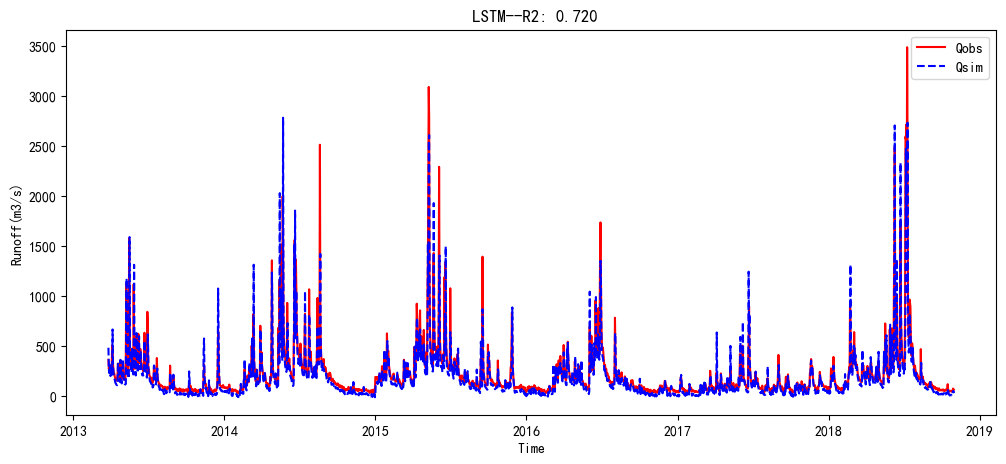

In [625]:
from tool import Indicator

mae,rmse,r2,nse,re,qmaxe,qmine = Indicator.eval(test_df_full['Qsim'], test_df_full['Qobs'])
# 比较预测值和原始值，进行绘图展示
plt.figure(figsize=(12, 5))
plt.plot(test_df_full['Qobs'], color='red', label='Qobs')
plt.plot(test_df_full['Qsim'], color='blue', label='Qsim', linestyle="--")
plt.title(' LSTM--' + 'R2: ' + format(r2, '.3f'))
plt.xlabel('Time')
plt.ylabel('Runoff(m3/s)')
plt.savefig("/Users/datou/PycharmProjects/model/JianyangSta/JY_picture/TestLSTM.png")
plt.legend()
plt.show()

MAE:55.90162123536627
RMSE:122.13829238007656
R2:0.7794635240279855
NSE:0.7794635240279854
RE:-18.457542604536986
Qmaxe:0.02949435084750277
Qmine:3.8228262554773464


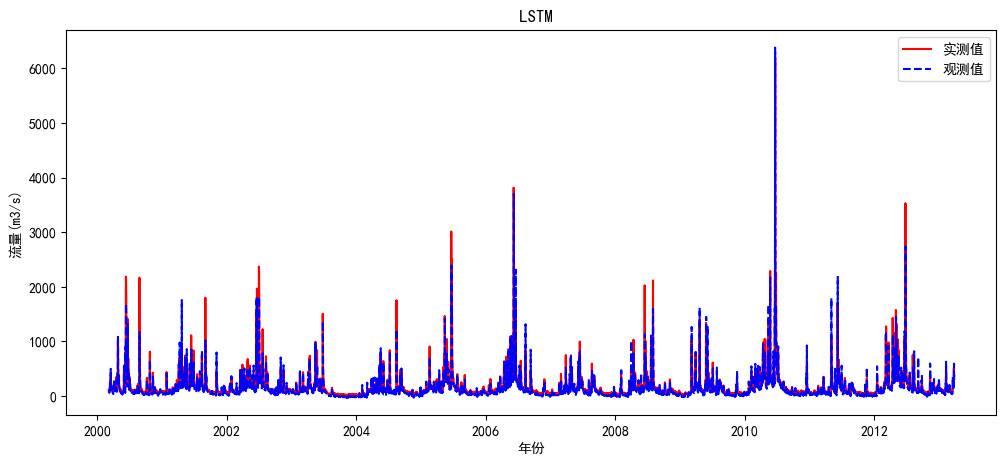

In [626]:
# 计算nash效率系数
train_mae,train_rmse,train_r2,train_nse,train_re,train_qmaxe,train_qmine = Indicator.eval(train_df_full['Qsim'], train_df_full['Qobs'])
# 比较预测值和原始值，进行绘图展示
plt.figure(figsize=(12, 5))
plt.plot(train_df_full['Qobs'], color='red', label='实测值')
plt.plot(train_df_full['Qsim'], color='blue', label='观测值', linestyle="--")
plt.title(' LSTM')
plt.xlabel('年份')
plt.ylabel('流量(m3/s)')
plt.legend()
plt.savefig("/Users/datou/PycharmProjects/model/JianyangSta/JY_picture/TrainLSTM.png")
plt.show()